In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [15]:
del df

In [16]:
df = pd.read_excel('test_clustering.xlsx')
df.head()

,ID,Condition,measure_1,measure_2,measure_3
0,3,A,1,1,1
1,2,B,1,1,1
2,1,C,1,1,1
3,0,A,1,1,1
4,20,B,1,1,1


In [17]:
# Sort over ID, else the one-hot encoding will change order

df.sort_values(by=['ID'], inplace=True, na_position='first')
df.reset_index(drop=True, inplace=True)
df

,ID,Condition,measure_1,measure_2,measure_3
0,0,A,1,1,1
1,1,C,1,1,1
2,2,B,1,1,1
3,3,A,1,1,1
4,4,A,10,10,10
5,5,A,10,10,10
6,6,A,10,10,10
7,7,A,8,8,8
8,8,A,5,5,5
9,9,A,6,6,6


### onehot encoding

In [ ]:
df_onehot = pd.get_dummies(df[['Condition']], prefix="", prefix_sep="")

This simple code work only if there is a single value in Condition

In [ ]:
df_onehot

With multiple values we must do something more.

Careful: the groupby reorders the index. Careful when you concatenate with the original df

In [18]:
x = df.set_index('ID').Condition.str.split(r',', expand=True).stack().reset_index(level=1, drop=True).to_frame('condition')
df_onehot2 = pd.get_dummies(x, prefix='cond', columns=['condition']).groupby(level=0).sum()
df_onehot2

,cond_A,cond_B,cond_C
ID,,,
0,1,0,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0
5,1,0,0
6,1,0,0
7,1,0,0
8,1,0,0


In [19]:
df_onehot2.reset_index(inplace=True)
df_onehot2.drop(['ID'],axis=1, inplace=True)

In [20]:
df_onehot2

,cond_A,cond_B,cond_C
0,1,0,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0
5,1,0,0
6,1,0,0
7,1,0,0
8,1,0,0
9,1,0,0


In [21]:
df[['measure_1','measure_2','measure_3']]

,measure_1,measure_2,measure_3
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,10,10,10
5,10,10,10
6,10,10,10
7,8,8,8
8,5,5,5
9,6,6,6


In [22]:
# Now concatenate the df
# Careful: the order of ID must be the same - the onehot has reordered the index. You nust reorder the df; or do a merge
# else this is wrong!!
# or use join instead

df_clustering = pd.concat([df[['measure_1','measure_2','measure_3']],df_onehot2], axis=1)

# now drop the original 'country' column (you don't need it anymore)
#df.drop(['Condition'],axis=1, inplace=True)

In [23]:
df_clustering

,measure_1,measure_2,measure_3,cond_A,cond_B,cond_C
0,1,1,1,1,0,0
1,1,1,1,0,0,1
2,1,1,1,0,1,0
3,1,1,1,1,0,0
4,10,10,10,1,0,0
5,10,10,10,1,0,0
6,10,10,10,1,0,0
7,8,8,8,1,0,0
8,5,5,5,1,0,0
9,6,6,6,1,0,0


Normalize the data set

In [24]:
from sklearn.preprocessing import StandardScaler
X = df_clustering #.values[:,1:]
X = np.nan_to_num(X)
#X

In [25]:
Clus_dataSet = StandardScaler().fit_transform(X)
#Clus_dataSet

Modelling - Run k-means to cluster 

In [26]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet) # df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 2, 4, 3, 3, 3, 3, 0, 0])

In [27]:
df_clustering.insert(0, 'cluster_label', kmeans.labels_)
#df_clustering

In [28]:
# add to origincal df

df = pd.concat([df, df_clustering[['cluster_label']]],axis=1)
df

,ID,Condition,measure_1,measure_2,measure_3,cluster_label
0,0,A,1,1,1,4
1,1,C,1,1,1,1
2,2,B,1,1,1,2
3,3,A,1,1,1,4
4,4,A,10,10,10,3
5,5,A,10,10,10,3
6,6,A,10,10,10,3
7,7,A,8,8,8,3
8,8,A,5,5,5,0
9,9,A,6,6,6,0


In [29]:
df.loc[df['cluster_label'] == 0] #, df.columns[0:5]]

,ID,Condition,measure_1,measure_2,measure_3,cluster_label
8,8,A,5,5,5,0
9,9,A,6,6,6,0
10,10,A,5,5,5,0
11,11,A,5,5,5,0
12,12,A,4,4,4,0


In [30]:
df.loc[df['cluster_label'] == 1]

,ID,Condition,measure_1,measure_2,measure_3,cluster_label
1,1,C,1,1,1,1
13,13,C,1,1,1,1
16,16,C,1,1,1,1
19,19,C,1,1,1,1


In [31]:
df.loc[df['cluster_label'] == 2]

,ID,Condition,measure_1,measure_2,measure_3,cluster_label
2,2,B,1,1,1,2
14,14,"B,A",1,1,1,2
17,17,"B,A",1,1,1,2
18,18,"A,B",1,1,1,2
20,20,B,1,1,1,2


In [32]:
df.loc[df['cluster_label'] == 3]

,ID,Condition,measure_1,measure_2,measure_3,cluster_label
4,4,A,10,10,10,3
5,5,A,10,10,10,3
6,6,A,10,10,10,3
7,7,A,8,8,8,3


In [33]:
df.loc[df['cluster_label'] == 4]

,ID,Condition,measure_1,measure_2,measure_3,cluster_label
0,0,A,1,1,1,4
3,3,A,1,1,1,4
15,15,A,1,1,1,4


Model performance valuation - Elbow method - https://bit.ly/2YnLCFr

n_clusters= 1  - number of iterations= 2
n_clusters= 2  - number of iterations= 3
n_clusters= 3  - number of iterations= 3
n_clusters= 4  - number of iterations= 2
n_clusters= 5  - number of iterations= 2
n_clusters= 6  - number of iterations= 3
n_clusters= 7  - number of iterations= 1
n_clusters= 8  - number of iterations= 2
n_clusters= 9  - number of iterations= 1


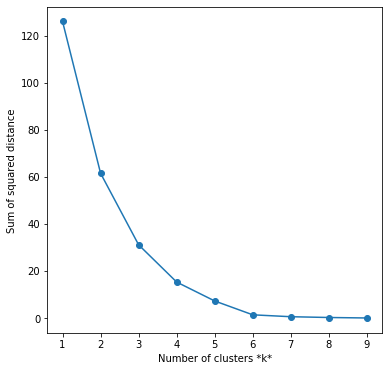

In [34]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet)
    sse.append(km.inertia_)
    print('n_clusters=',k,' - number of iterations=', km.n_iter_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');


#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet) # df_clustering)

K=5 or 6 seems the best number